<a href="https://colab.research.google.com/github/maggiecrowner/DS4002-Project-2/blob/main/SCRIPTS/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/maggiecrowner/DS4002-Project-2.git

Cloning into 'DS4002-Project-2'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.91 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (15/15), done.


###Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
df = pd.read_csv('/content/DS4002-Project-2/DATA/raw_temperature_data.csv').drop(columns=['Unnamed: 0', 'tmin'])
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 1970) & (df['Date'].dt.year <= 2023)]
df.set_index('Date', inplace=True)
df_monthly = df.resample('ME').mean()
df_monthly = df_monthly.reset_index()
df_monthly['tmax_diff'] = df_monthly['tmax'].diff(12)
df_monthly.dropna(subset=['tmax_diff'], inplace=True)

### Analysis

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check for stationarity
print(adfuller(df_monthly['tmax_diff']))

print(adfuller(df_monthly['prcp']))

(np.float64(-10.020630207071683), np.float64(1.682759743692555e-17), 12, 623, {'1%': np.float64(-3.440890045708521), '5%': np.float64(-2.8661904001753618), '10%': np.float64(-2.569246579178572)}, np.float64(3463.34749344812))
(np.float64(-22.89748158549549), 0.0, 0, 635, {'1%': np.float64(-3.4406900498266193), '5%': np.float64(-2.8661023102613137), '10%': np.float64(-2.569199643499287)}, np.float64(-1372.0315188217735))


p-value: 1.68e-17 --> The seasonally differenced data is stationary.

p-value: 0.0 --> The exogenous variable is stationary.

*Examine new ACF/PACF plots for possible parameter values*

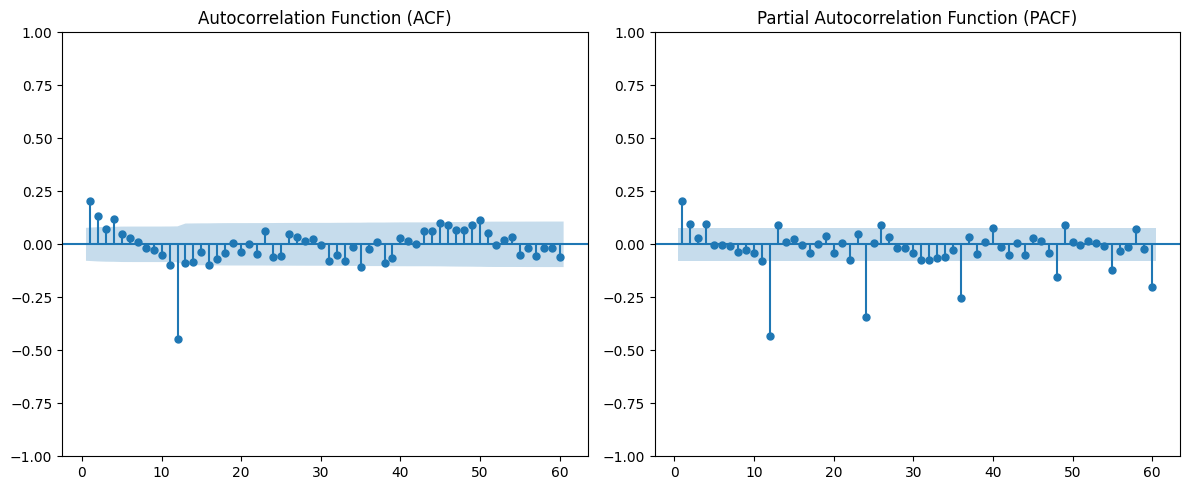

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot
plot_acf(df_monthly['tmax_diff'], ax=axes[0], lags=60, zero=False)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
plot_pacf(df_monthly['tmax_diff'], ax=axes[1], lags=60, method="ywm", zero=False)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**Candidate parameters:**

p: 2 or possibly 1

d: 0

q: 2

P: 0

D: 0

Q: 1

s: 12

**Possible models:**

SARIMAX(2,0,0)x(0,0,1,12)

SARIMAX(2,0,0)x(0,0,0,12)

SARIMAX(1,0,0)x(0,0,1,12)

SARIMAX(1,0,0)x(0,0,0,12)

SARIMAX(0,0,2)x(0,0,1,12)

SARIMAX(0,0,2)x(0,0,0,12)

*Grid search for optimal parameter values*

In [4]:
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)
train_data = df_monthly['tmax_diff']['1970-01-01':'2022-12-31']  # Training data from 1970 to 2022
test_data = df_monthly['tmax_diff']['2023-01-01':]  # Test data from 2023 onwards
train_exog = df_monthly['prcp']['1970-01-01':'2022-12-31']
test_exog = df_monthly['prcp']['2023-01-01':]

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings("ignore")

def sarimax_grid_search(data, seasonal_period=12):
    # Define the parameter grid
    p = q = range(0, 3)  # Try AR and MA terms of 0, 1, 2
    d = range(0, 2)  # Try differencing from 0 to 1
    P = Q = range(0, 2)  # Seasonal AR and MA terms
    D = [0]  # Seasonal differencing
    seasonal = [seasonal_period]

    # Create the parameter grid
    param_grid = list(product(p, d, q, P, D, Q, seasonal))

    # Initialize variables to store the best model
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Perform grid search
    for param in param_grid:
        (p, d, q, P, D, Q, s) = param

        try:
            # Fit SARIMAX model
            model = SARIMAX(data,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, s),
                            exog=train_exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)

            # Check if the model's AIC is the lowest we've seen
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, s)
                best_model = result
        except Exception as e:
            continue  # Skip models that fail to converge or fit

    print(f"Best Model AIC: {best_aic}")
    print(f"Best Model Order: {best_order}")
    print(f"Best Seasonal Order: {best_seasonal_order}")

    return best_model

best_sarimax_model = sarimax_grid_search(train_data)

Best Model AIC: 3171.86095735438
Best Model Order: (1, 0, 2)
Best Seasonal Order: (0, 0, 1, 12)


**Optimized parameters:**

p: 1

d: 0

q: 2

P: 0

D: 0

Q: 1

s: 12

**Optimized model:**

SARIMAX(1,0,2)x(0,0,1,12)

                                      SARIMAX Results                                       
Dep. Variable:                            tmax_diff   No. Observations:                  624
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -1579.930
Date:                              Mon, 17 Mar 2025   AIC                           3171.861
Time:                                      17:30:10   BIC                           3198.332
Sample:                                  01-31-1971   HQIC                          3182.159
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp           0.1151      0.098      1.169      0.242      -0.078       0.308
ar.L1          0.67

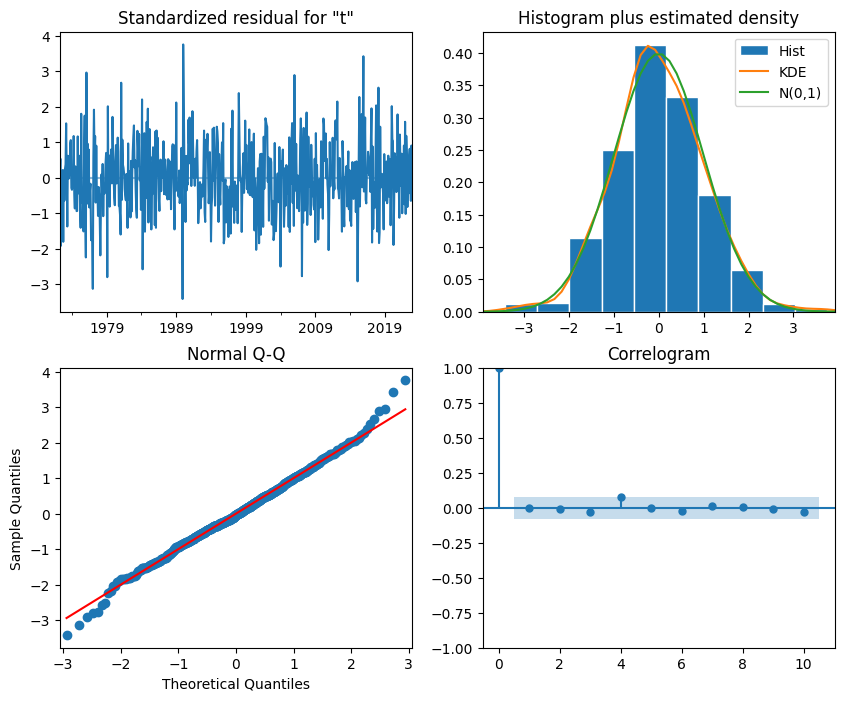

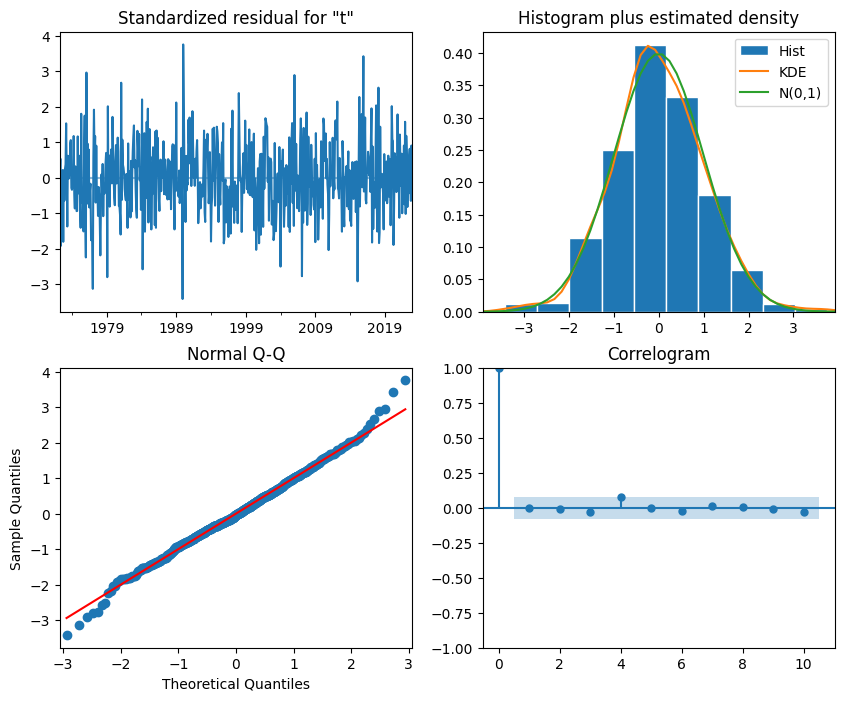

In [13]:
import statsmodels.stats.api as sms

# Fit the final SARIMAX model using the best parameters
final_model = sm.tsa.SARIMAX(train_data,
                             order=(1,0,2),
                             seasonal_order=(0,0,1,12),
                             exog=train_exog,
                             enforce_stationarity=False,
                             enforce_invertibility=False)

# Fit the model and suppress the display of convergence output
final_result = final_model.fit(disp=False)

# Print the summary of the model fit
print(final_result.summary())

# Check the residuals and diagnostics
final_result.plot_diagnostics(figsize=(10, 8))


                               SARIMAX Results                                
Dep. Variable:              tmax_diff   No. Observations:                  624
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1808.896
Date:                Mon, 17 Mar 2025   AIC                           3625.791
Time:                        17:32:03   BIC                           3643.523
Sample:                    01-31-1971   HQIC                          3632.682
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp          -2.1672      1.526     -1.420      0.155      -5.157       0.823
ar.L1          0.1953      0.036      5.401      0.000       0.124       0.266
ar.L2          0.0927      0.040      2.293      0.0

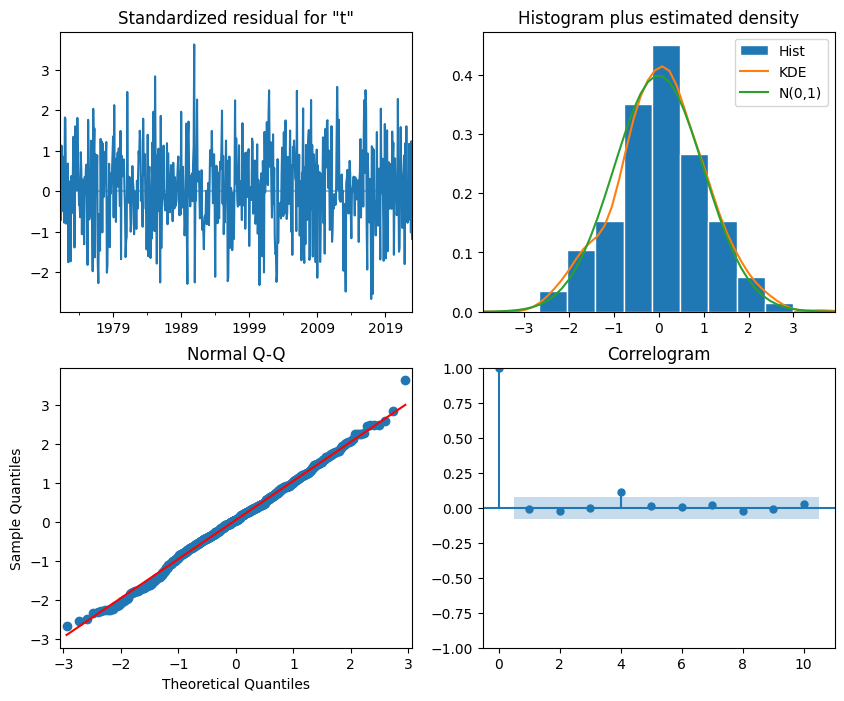

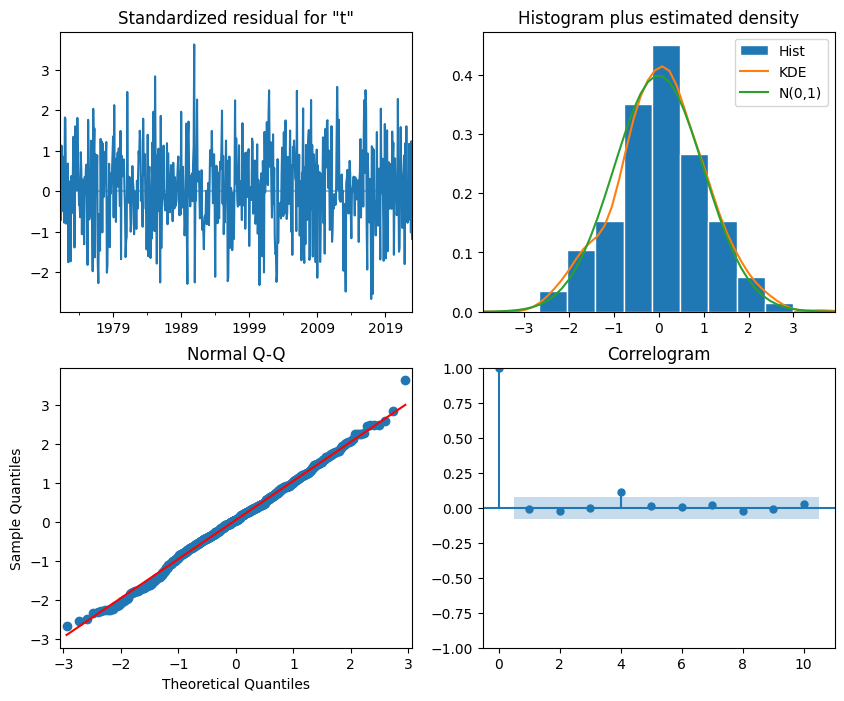

In [16]:
import statsmodels.stats.api as sms

# Fit the final SARIMAX model using the observed possible parameters
final_model = sm.tsa.SARIMAX(train_data,
                             order=(2,0,0),
                             seasonal_order=(0,0,0,12),
                             exog=train_exog,
                             enforce_stationarity=False,
                             enforce_invertibility=False)

# Fit the model and suppress the display of convergence output
final_result = final_model.fit(disp=False)

# Print the summary of the model fit
print(final_result.summary())

# Check the residuals and diagnostics
final_result.plot_diagnostics(figsize=(10, 8))


                               SARIMAX Results                                
Dep. Variable:              tmax_diff   No. Observations:                  624
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1813.971
Date:                Mon, 17 Mar 2025   AIC                           3633.941
Time:                        17:32:38   BIC                           3647.245
Sample:                    01-31-1971   HQIC                          3639.112
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp          -1.9602      1.419     -1.382      0.167      -4.741       0.820
ar.L1          0.2149      0.035      6.165      0.000       0.147       0.283
sigma2        19.7952      1.114     17.763      0.0

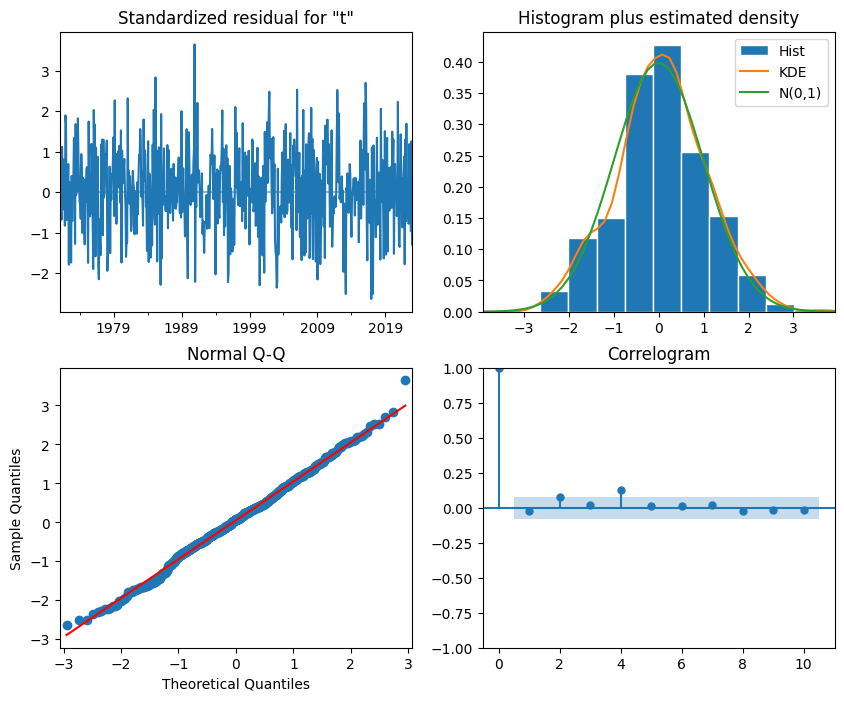

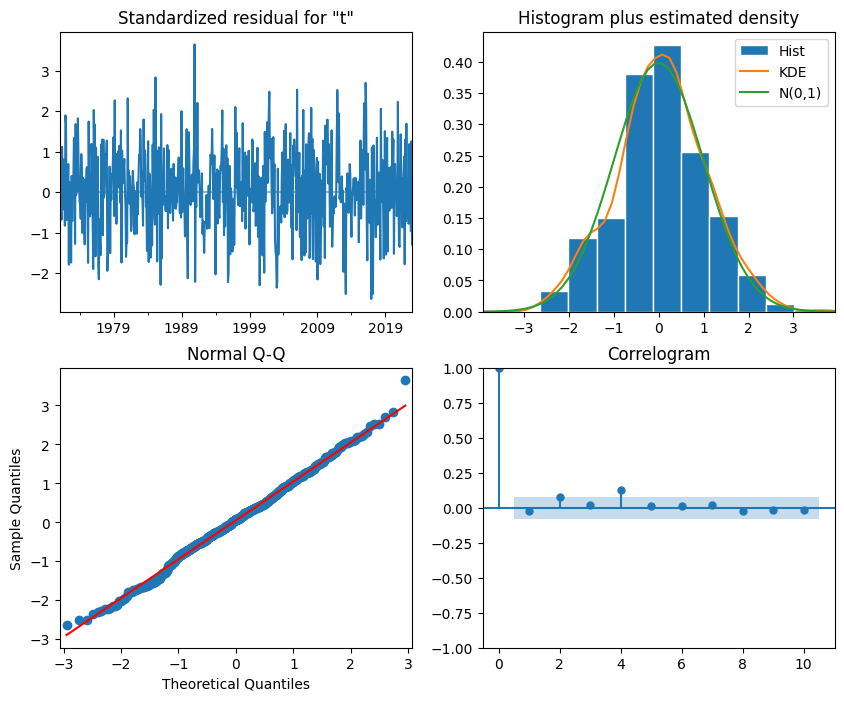

In [17]:
import statsmodels.stats.api as sms

# Fit the final SARIMAX model using the best parameters
final_model = sm.tsa.SARIMAX(train_data,
                             order=(1,0,0),
                             seasonal_order=(0,0,0,12),
                             exog=train_exog,
                             enforce_stationarity=False,
                             enforce_invertibility=False)

# Fit the model and suppress the display of convergence output
final_result = final_model.fit(disp=False)

# Print the summary of the model fit
print(final_result.summary())

# Check the residuals and diagnostics
final_result.plot_diagnostics(figsize=(10, 8))


                               SARIMAX Results                                
Dep. Variable:              tmax_diff   No. Observations:                  624
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1807.708
Date:                Mon, 17 Mar 2025   AIC                           3623.416
Time:                        17:33:31   BIC                           3641.141
Sample:                    01-31-1971   HQIC                          3630.305
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp          -1.9994      1.452     -1.377      0.168      -4.845       0.846
ma.L1          0.1962      0.036      5.399      0.000       0.125       0.267
ma.L2          0.1023      0.043      2.399      0.0

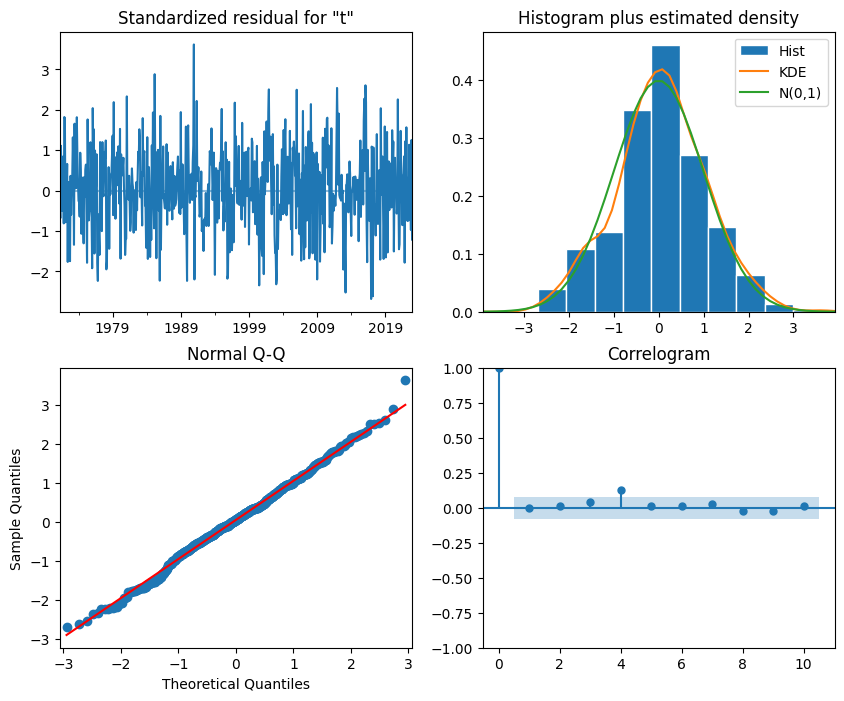

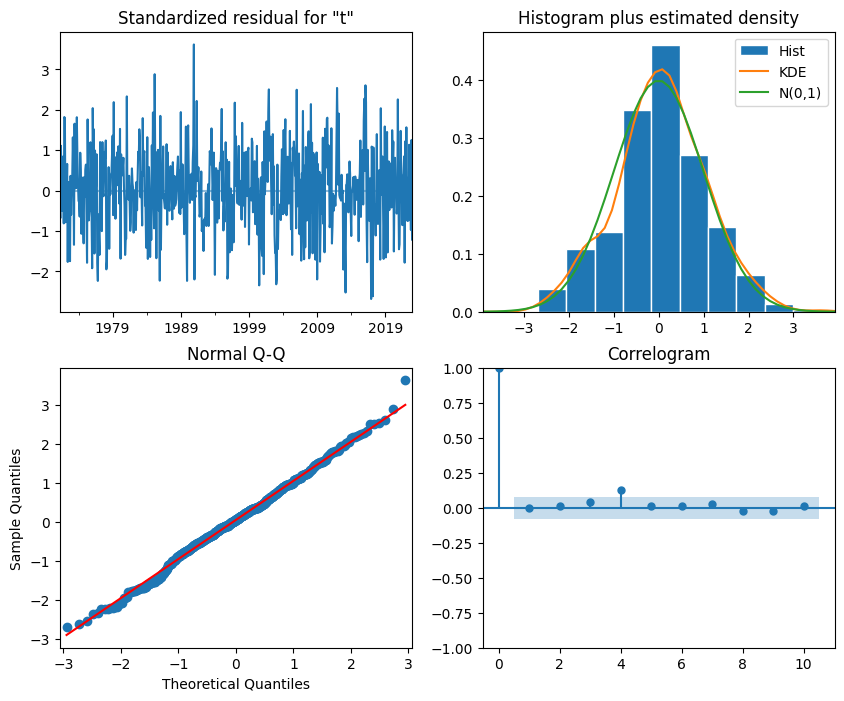

In [19]:
import statsmodels.stats.api as sms

# Fit the final SARIMAX model using the best parameters
final_model = sm.tsa.SARIMAX(train_data,
                             order=(0,0,2),
                             seasonal_order=(0,0,0,12),
                             exog=train_exog,
                             enforce_stationarity=False,
                             enforce_invertibility=False)

# Fit the model and suppress the display of convergence output
final_result = final_model.fit(disp=False)

# Print the summary of the model fit
print(final_result.summary())

# Check the residuals and diagnostics
final_result.plot_diagnostics(figsize=(10, 8))

**Candidate models (from observation of ACF/PACF plots and grid search) that met diagnostics and should be considered further:**

1) SARIMAX(2,0,0)x(0,0,0,12)

2) SARIMAX(1,0,0)x(0,0,0,12)

3) SARIMAX(0,0,2)x(0,0,0,12)

**Model 1**

AIC: 3625.791

BIC: 3643.523

HQIC: 3632.682

**Model 2**

AIC: 3633.941

BIC: 3647.245

HQIC: 3639.112

**Model 3**

AIC: 3623.416

BIC: 3641.141

HQIC: 3630.305

---
Model 3 is the lowest on all three evaluation criterion, meaning that it is the best fit for this data. Model 3 is SARIMAX(0,0,2)x(0,0,0,12). However, seasonal differencing was done on the data prior to fitting this model, so our final model for the work that was done overall is SARIMAX(0,0,2)x(0,1,0,12).
